# DTSA-5510:  Final Project
### June 2, 2022


## An Unsupervised Machine Learning Approach for Movie Recommendations Based on User Submitted Reviews
### Introduction

This is the Final Project for DTSA-5510, Unsupervised Algorithms in Machine Learning.  This project applies unsupervised learning algorithms to movie data in an attempt to generate a movie recommendation system based _solely_ on the reviews submitted by users.  
  
All other movie recommendation systems I'd read about were essentially genre based, where films are recommended based on how similar the recommended films genres are to the film in question. Mine is an entirely different approach in that a film's genre(s) and its ratings are not given to the unsupervised algorithm. Instead, only the text of user submitted reviews are utilized in training the model.

This approach had several challenges, the first of which was just finding the data. The movies.csv file as well and the train and test csv files are the same as ones used during Week 3 of the course. Finding user reviews proved more difficult, but I found a large set on [Kaggle](https://www.kaggle.com/),  IMDB_reviews.json, which is part of a larger dataset, [IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset?select=IMDB_reviews.json).

However, I still needed a way to link the files from the course to the user reviews. This I was able to get using the links.csv file from the [MovieLens 25M Dataset](https://grouplens.org/datasets/movielens/).
  
All of these files, with the exception of the IMDB Reviews file, as well as the Jupyter notebook used to this create report, can be found at and cloned from https://github.com/clayv/DTSA-5510_Final_Project. The IMDB Reviews file is too large, even if compressed, to be uploaded to GitHub and must be downloaded separately from the [IMDB Spoiler Dataset](https://www.kaggle.com/datasets/rmisra/imdb-spoiler-dataset?select=IMDB_reviews.json) on [Kaggle](https://www.kaggle.com/).

**References:**  
Beysolow, T. (2018). _Applied Natural Language Processing with Python_. Apress  
Nixon, A. (2020, August 28). Building a movie content based recommender using tf-idf. Towards Data Science. https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5

In [260]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import sklearn.metrics as metrics 

randomState = 42

### Step 0: Load the data

In [261]:
dfReviews = pd.read_json("./data/IMDB_reviews.json.zip", orient = "records", lines = True, compression="zip")
dfLinks = pd.read_csv("./data/links.csv")
dfMovies = pd.read_csv("./data/movies.csv")
dfTrain = pd.read_csv("./data/train.csv")
dfTest = pd.read_csv("./data/test.csv")


Initial examination of the data revealed no null data in any of the fields of interest for this project

In [262]:
def printDfInfo(df, name):
    print("{} dataframe:".format(name))
    df.info()
    #print(df.head())
    print()
    
printDfInfo(dfReviews, "Reviews")
printDfInfo(dfLinks, "Links")
printDfInfo(dfMovies, "Movies")
printDfInfo(dfTrain, "Training")
printDfInfo(dfTest, "Test")


Reviews dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB

Links dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB

Movies dataframe:
<class 'pandas.core.f

### Step 1:  Data Wrangling
Although the links.csv file does provide for linking between the Movies and Reviews files, the format of the each of the files uses is different.  The imdbId and movie_id, from Links and Reviews respectively, hold the mapping field but Links uses and numeric field, int64, and Reviews an object. Further complicating this is the Reviews file stores the field with a prepended with a "tt" and sometime a leading 0 as well

In [266]:
dfLinks.head(2)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


In [267]:
dfReviews.head(2)

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.


The following cell strips the leading "tt" and the conversion to an int64 will drop a leading 0 if present.  This modified field is then inserted into the Reviews dataframe as an int64 named "imdbId" to match the field name in Links

In [117]:
# Add imdbId column to dfReviews
dfReviews.insert(1, "imdbId", np.int64(dfReviews.movie_id.str.strip('tt')), True)
dfReviews.head()


,review_date,imdbId,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,111161,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,111161,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,111161,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,111161,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,111161,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [118]:
# Drop unneeded columns
dfReviews.drop(['review_date', 'user_id', 'is_spoiler', 'rating', 'review_summary'], axis = 1, inplace = True)
dfMovies.drop(dfMovies.iloc[:, 2:21], axis = 1, inplace = True)
dfMovies.head()


,mID,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II


In [119]:
def collectReviews():
    dfMovies['all_reviews'] = ""
    for index in range(len(dfMovies)):
        allReviews = ""
        for imdbId in dfLinks[dfLinks.movieId == dfMovies.iloc[index, 0]].imdbId:
            for review in dfReviews[dfReviews.imdbId == imdbId].review_text:
                allReviews += (review + " ")
            if len(allReviews) > 0:
                dfMovies.iloc[index, 2] = allReviews
            else:
                dfMovies.iloc[index, 2] = np.nan

collectReviews()
dfMovies.dropna(axis = 0, how = 'any', subset = ["all_reviews"], inplace = True)
dfMovies.info()
dfMovies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 3879
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   mID          595 non-null    int64 
 1   title        595 non-null    object
 2   all_reviews  595 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.6+ KB


,mID,title,all_reviews
0,1,Toy Story,Toy Story  5/5 starsChildren play with toys. ...
1,2,Jumanji,There are few children's movies that I particu...
5,6,Heat,I remember seeing this in my childhood and bei...
6,7,Sabrina,They don't make 'em like they used to. In fact...
9,10,GoldenEye,I hated this one. There were just too many imp...


In [120]:
dfMovies.all_reviews.replace(to_replace = "’", value = "\'", inplace = True, regex = True)
dfMovies.all_reviews.replace(to_replace = "\\d+", value = "", inplace = True, regex = True)


In [238]:
nTopWords = 60
tf_vectorizer = CountVectorizer(max_df = 0.80, min_df = 2, max_features = nTopWords, stop_words = "english")
tf = tf_vectorizer.fit_transform(dfMovies.all_reviews)     


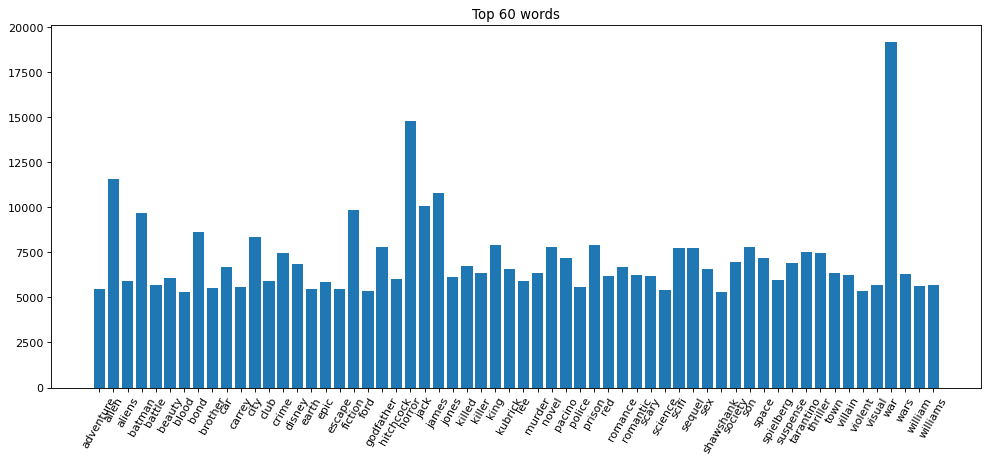

In [239]:
from matplotlib.pyplot import figure

figure(figsize=(15, 6), dpi=80)
plt.title("Top {} words".format(nTopWords))
plt.bar(x = tf_vectorizer.get_feature_names_out(), height = np.sum(tf.toarray(), axis=0))
plt.xticks(rotation = 60)
plt.show() 

In [123]:
dfMovies.all_reviews = dfMovies.all_reviews.transform(lambda review: review.lower())
dfMovies.all_reviews.replace(to_replace = "\\bsci.?fi\\b", value = "scifi", inplace = True, regex = True)
for word in ("andy", "bruce", "edward", "david", "dr", "george", "jack" "james", "jim", "kevin", \
             "michael", "peter", "robert", "robin", "smith", "tim", "tom"):
    dfMovies.all_reviews.replace(to_replace = "\\b" + word + "\\b", value = "", inplace = True, regex = True)


In [124]:
dfTrain = dfTrain[dfTrain['mID'].isin(dfMovies['mID'])]
dfTest = dfTest[dfTest['mID'].isin(dfMovies['mID'])]

In [240]:
def fitNMF(tfidf, n_topicLabels, alpha, lossFunc, solverArg):
    #print("Fitting the NMF model with {} loss function and solver {}".format(lossFunc, solverArg))
    nmf = NMF(
        n_components = n_topicLabels,
        random_state = randomState,
        init = "nndsvda",
        beta_loss = lossFunc,
        solver = solverArg,
        max_iter = 1000,
        alpha_W = alpha,
        alpha_H = alpha,
        l1_ratio = 0.5,
    ).fit(tfidf)
    return nmf

nClusters = 18

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df = 0.80, min_df = 2, max_features = 100, stop_words = "english")

tfidfTrans = tfidf_vectorizer.fit_transform(dfMovies.all_reviews)
nmfFit = fitNMF(tfidfTrans, nClusters, 0.00005, "kullback-leibler", "mu")

nmfTrans = nmfFit.transform(tfidfTrans)


Extracting tf-idf features for NMF...


In [241]:
mid2idx = dict(zip(dfMovies.mID, list(range(len(dfMovies)))))
idx2Mid = dict(zip(list(range(len(dfMovies))), dfMovies.mID))
cosDist = distance.pdist(nmfTrans, metric = 'cosine')
cosDist[np.isnan(cosDist)] = 0
cosSim = ((1 - distance.squareform(cosDist)) * .5) + .5


In [253]:
def findSimilar(cosSim, mID):
    mIndex = mid2idx[mID]

    movieIDs = {} 
    [movieIDs.setdefault(i, []) for i in range(1, 6)] 

    sortedSim = np.argsort(cosSim[mIndex])
    for i in range(len(sortedSim) - 1, -1, -1):
        itemSim = cosSim[mIndex, sortedSim[i]]
        
        if itemSim == 1:
            continue
        elif (itemSim >= .93):
            movieIDs[5].append(idx2Mid[sortedSim[i]])
        elif (itemSim >= .83):
            movieIDs[4].append(idx2Mid[sortedSim[i]])
        elif (itemSim >= .73):
            movieIDs[3].append(idx2Mid[sortedSim[i]])
        elif (itemSim >= .63):
            movieIDs[2].append(idx2Mid[sortedSim[i]])
        else:
            movieIDs[1].append(idx2Mid[sortedSim[i]])
    return movieIDs

def showTopN(movieID, dictMovies, nTop = 5):
    print()
    print("Movies like: {}".format(dfMovies[dfMovies.mID == movieID].title.to_string(index=False)))
    for rank in range(5, 0, -1):
        line = "Rank {}: ".format(rank)
        for i in range(min(nTop, len(dictMovies[rank]))):
            movie = dfMovies.loc[dfMovies.mID == dictMovies[rank][i]]
            #line += str(i) + "-" + movie.mID.to_string(index=False) + ": " 
            line += movie.title.to_string(index=False) + "; "
        print(line)

for mId in dfMovies.head(5).mID:
    simMovieIDs = findSimilar(cosSim, mId)
    showTopN(mId, simMovieIDs, 3)



Movies like: Toy Story
Rank 5: Bug's Life, A; Lion King, The; Tarzan; 
Rank 4: George of the Jungle; Newsies; Stand by Me; 
Rank 3: Super Mario Bros.; Stuart Little; Space Jam; 
Rank 2: Sister Act; Sister Act 2: Back in the Habit; Snow Day; 
Rank 1: Monty Python's Life of Brian; Office Space; Cool Runnings; 

Movies like: Jumanji
Rank 5: Hook; Good Will Hunting; Mrs. Doubtfire; 
Rank 4: Fisher King, The; Awakenings; Borrowers, The; 
Rank 3: Godzilla; Raiders of the Lost Ark; Beverly Hills Cop III; 
Rank 2: Postman, The; Free Willy; Flintstones, The; 
Rank 1: Island of Dr. Moreau, The; Jungle2Jungle (a.k.a. Jungle 2 Jungle); Twister; 

Movies like: Heat
Rank 5: Carlito's Way; Dog Day Afternoon; Scent of a Woman; 
Rank 4: Mars Attacks!; Backdraft; Casino; 
Rank 3: Awakenings; Deer Hunter, The; 
Rank 2: Nightmare Before Christmas, The; End of Days; Following; 
Rank 1: Elizabeth; Rainmaker, The; Blade; 

Movies like: Sabrina
Rank 5: Death Becomes Her; Six Days Seven Nights; Cruel Intentio

In [254]:
print((cosSim < 0.1).any())
print(len(dfTest[dfTest.rating == 5].uID.unique()))

False
5502


In [256]:
def getAccuracy(df):
    actual = []
    pred = []
    like = []
    within1 = []
    within2 = []
    for uId in df[df.rating == 5].uID.unique():
        dfUser = df.loc[df.uID == uId]
        dictUser = dict(zip(dfUser.mID, dfUser.rating))
        for mId in dfUser.loc[dfUser.rating == 5].mID:
            simMovieIDs = findSimilar(cosSim, mId)
            for rank in simMovieIDs:
                if rank < 4:
                    continue
                for movieId in simMovieIDs[rank]:
                    if movieId in dictUser:
                        rating = dictUser[movieId]
                        actual.append(rating)
                        pred.append(rank)
                        if rating >= rank:
                            like.append(rating)
                        else:
                            like.append(rank)
                        if rank - 1 <= rating <= rank + 1:
                            within1.append(rating)
                        else:
                            within1.append(rank)
                        if rank - 2 <= rating <= rank + 2:
                            within2.append(rating)
                        else:
                            within2.append(rank)

    return actual, pred, like, within1, within2

actual, pred, like, within1, within2 = getAccuracy(dfTest)
print("Done!")        


Done!


In [223]:
print(metrics.accuracy_score(actual, pred), metrics.mean_squared_error(actual, pred) ** .5)
print(metrics.accuracy_score(actual, like), metrics.mean_squared_error(actual, like) ** .5)
print(metrics.accuracy_score(actual, within1), metrics.mean_squared_error(actual, within1) ** .5)
print(metrics.accuracy_score(actual, within2), metrics.mean_squared_error(actual, within2) ** .5)


0.35484177515917514 1.3540456699665617
0.49108754972101926 1.3027639470730492
0.7774398935664735 1.1877885156659398
0.9235144784892956 0.9091442230232825


In [229]:
print(metrics.accuracy_score(actual, pred), metrics.mean_squared_error(actual, pred) ** .5)
print(metrics.accuracy_score(actual, like), metrics.mean_squared_error(actual, like) ** .5)
print(metrics.accuracy_score(actual, within1), metrics.mean_squared_error(actual, within1) ** .5)
print(metrics.accuracy_score(actual, within2), metrics.mean_squared_error(actual, within2) ** .5)

0.3640099554320773 1.3287746924326211
0.4991028535046594 1.2769296320380479
0.7859582103374428 1.1591781262360161
0.9295595300109972 0.8770910156020432


In [231]:
print(metrics.accuracy_score(actual, pred), metrics.mean_squared_error(actual, pred) ** .5)
print(metrics.accuracy_score(actual, like), metrics.mean_squared_error(actual, like) ** .5)
print(metrics.accuracy_score(actual, within1), metrics.mean_squared_error(actual, within1) ** .5)
print(metrics.accuracy_score(actual, within2), metrics.mean_squared_error(actual, within2) ** .5)

0.3141944531006544 1.3406445569142462
0.6214552820193207 1.0858124983402453
0.7388594577750078 1.1716069406202074
0.9525942661265192 0.7195301174401226


In [255]:
print(len(actual))

32496


In [252]:
print(metrics.accuracy_score(actual, pred), metrics.mean_squared_error(actual, pred) ** .5)
print(metrics.accuracy_score(actual, like), metrics.mean_squared_error(actual, like) ** .5)
print(metrics.accuracy_score(actual, within1), metrics.mean_squared_error(actual, within1) ** .5)
print(metrics.accuracy_score(actual, within2), metrics.mean_squared_error(actual, within2) ** .5)

0.3542282127031019 1.2241291280364732
0.5891494337764648 1.1240866964046738
0.8338872476612507 1.0093726205664524
0.943685376661743 0.761341297413465


In [257]:
print(metrics.accuracy_score(actual, pred), metrics.mean_squared_error(actual, pred) ** .5)
print(metrics.accuracy_score(actual, like), metrics.mean_squared_error(actual, like) ** .5)
print(metrics.accuracy_score(actual, within1), metrics.mean_squared_error(actual, within1) ** .5)
print(metrics.accuracy_score(actual, within2), metrics.mean_squared_error(actual, within2) ** .5)

0.3527717448113262 1.2569085287803075
0.5668923705880303 1.1686310041856551
0.8193633058849491 1.0550959618191391
0.9389205700282227 0.796867888720558
